In [1]:
import random
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
sns.set_style('darkgrid')

In [2]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq

In [54]:
import warnings
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, RepeatVector, SpatialDropout1D, SimpleRNN, GRU, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [5]:
def make_window_ma(lower = 10, upper = 100):
    """
    Генерация размера скользящего окна, диапазоны указываем в аргументах
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

def make_observing_window(lower = 10, upper = 300):
    """
    Генерация окна наблюдения. То окно, которое будем использовать для обнаружения нестационарности.
    :param lower: int
    :param upper: int
    :return: int
    """
    return random.randint(lower, upper)

In [6]:
def get_corr_coef(data, back_steps): #  шаг смещения >= 0
    """
    Calculate correlation coefficient
    :param data: numpy 1D array
    :param back_steps:  autocorrelation shift
    :return: correlation coefficient, float
    """

    return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

def make_autocorrelation_dependence(x, steps_max_part_window = 0.5):
    """
    It takes a numpy array, and the maximum number of steps to calculate the autocorrelation function. The number of steps is expressed in terms of a fraction of the window (the length of the received signal).
    :param x: numpy 1D array
    :param steps_max_part_window: fraction of the array window, default 0.5
    :return: numpy array
    """
    N = int(x.shape[0] * steps_max_part_window)
    steps = range(0, N + 1)
    coefs = [get_corr_coef(x, i) for i in steps]

    return np.array(coefs)

In [7]:
def make_random_signal(length, ma):
    """
    The function creates a smooth signal obtained from noise.
    :param length: size of creating signal
    :param ma: value of moving average window
    :return: nunpy array 1D
    """

    x = np.random.normal(0,1,max(length*2, ma * 2))
    x = pd.Series(x).rolling(window = ma).mean().dropna().values
    abs_x = np.abs(x)
    max_value =abs_x.max()
    x = x/max_value
    x = x[:length]

    return x

In [8]:
def make_abs_spectr(signal, normalise = True):
    """
    Function receive numpy array signal, calculate abs FFT.
    If you want you may normalise it, as default
    :param signal: numpy array
    :param normalize: normalise [0,1]
    :return: numpy array FFT
    """
    signal_fft = np.abs(rfft(signal))
    if normalise:
        signal_fft = signal_fft / signal_fft.max()
    signal_fft = np.array(signal_fft)
    return signal_fft

# Make data

In [47]:
N=1000
one_signal = []
for i in range(N):
    ma = make_window_ma(10,100)
    window = make_observing_window(10, 300)
    signal = make_random_signal(window, ma)
    one_signal.append(signal.tolist())
one_signal = pad_sequences(one_signal, dtype='float', maxlen=300)
y_one_signal = np.zeros(one_signal.shape[0])

In [48]:
two_signals = []
for i in range(N):
    ma1 = make_window_ma(10,100)
    window = make_observing_window(10, 300)
    signal1 = make_random_signal(window, ma)
    ma2 = make_window_ma(10,100)
    signal2 = make_random_signal(window, ma2)
    t1 = int(0.9 * window)
    t2 = window - t1
    signal = np.concatenate([signal1[-t1:], signal2[-t2:]])
    two_signals.append(signal.tolist())
two_signals = pad_sequences(two_signals, dtype='float', maxlen=300)
y_two_signals = np.ones(two_signals.shape[0])

In [49]:
y = np.concatenate([y_one_signal, y_two_signals])
y = to_categorical(y)
X = np.concatenate([one_signal, two_signals])
print(X.shape)
print(y.shape)

(2000, 300)
(2000, 2)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1400, 300)
(1400, 2)
(600, 300)
(600, 2)


In [56]:
def compile_and_learn(model, X_train, y_train, X_test, y_test,  epochs, optimizer, loss, metrics, batch_size):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        verbose = 1)

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model

def compile_and_learn2(model, X_train,  y_train, X_test, y_test,  epochs, optimizer, loss, metrics, batch_size):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
    model.summary()

    # Обучение модели
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        verbose = 1)

    f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    axes[0].plot(history.history['loss'], label='Ошибка на обучающем наборе')
    axes[0].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Ошибка')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Точность на обучающем наборе')
    axes[1].plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Точность')
    axes[1].legend()

    print('Тестовые данные')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(np.argmax(y_test, axis=1), y_pred))
    print('Тренировочные данные')
    y_pred = np.argmax(model.predict(X_train), axis=1)
    print(classification_report(np.argmax(y_train, axis=1), y_pred))
    return model



In [57]:
input = Input(X_train.shape[1])

x = Reshape((X_train.shape[1],1))(input)

x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
model = Model(input,x)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130 

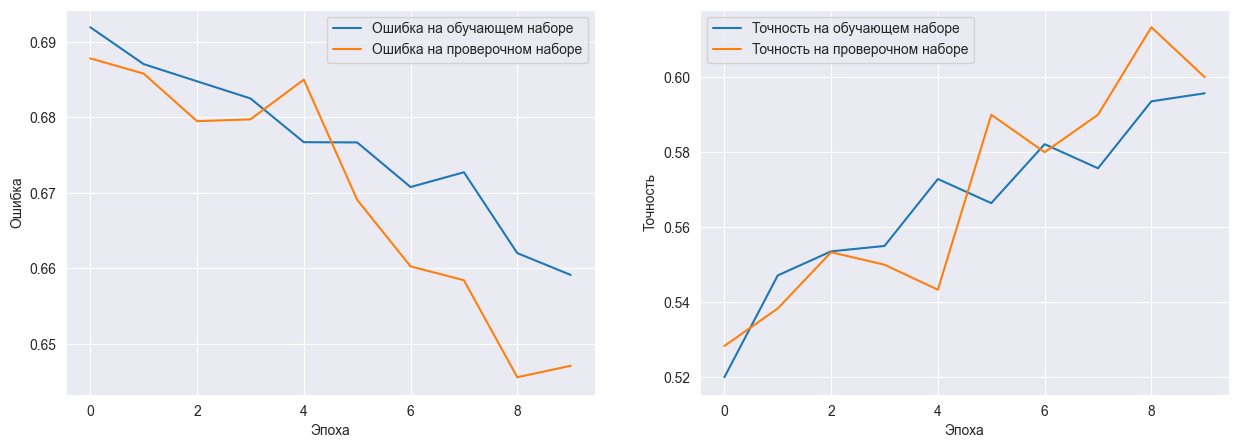

In [58]:
compile_and_learn2(model, X_train, y_train, X_test, y_test, epochs = 10, optimizer = Adam(lr=1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'], batch_size = 16)